In [94]:
import transitleastsquares as tls
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from astropy.time import Time

In [3]:
%config InlineBackend.figure_format="retina" 

In [50]:
sns.set(context="talk", style="white")

## Download data

In [9]:
srs = lk.search_lightcurve("WASP-50", author="SPOC", exptime=120)
srs

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,382391899,0.0
1,TESS Sector 31,2020,SPOC,120,382391899,0.0


In [65]:
lcs = srs.download_all()
lcs

LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 382391899" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 382391899" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

We have two TESS datasets to work with

## SAP

Text(0.5, 1.0, '')

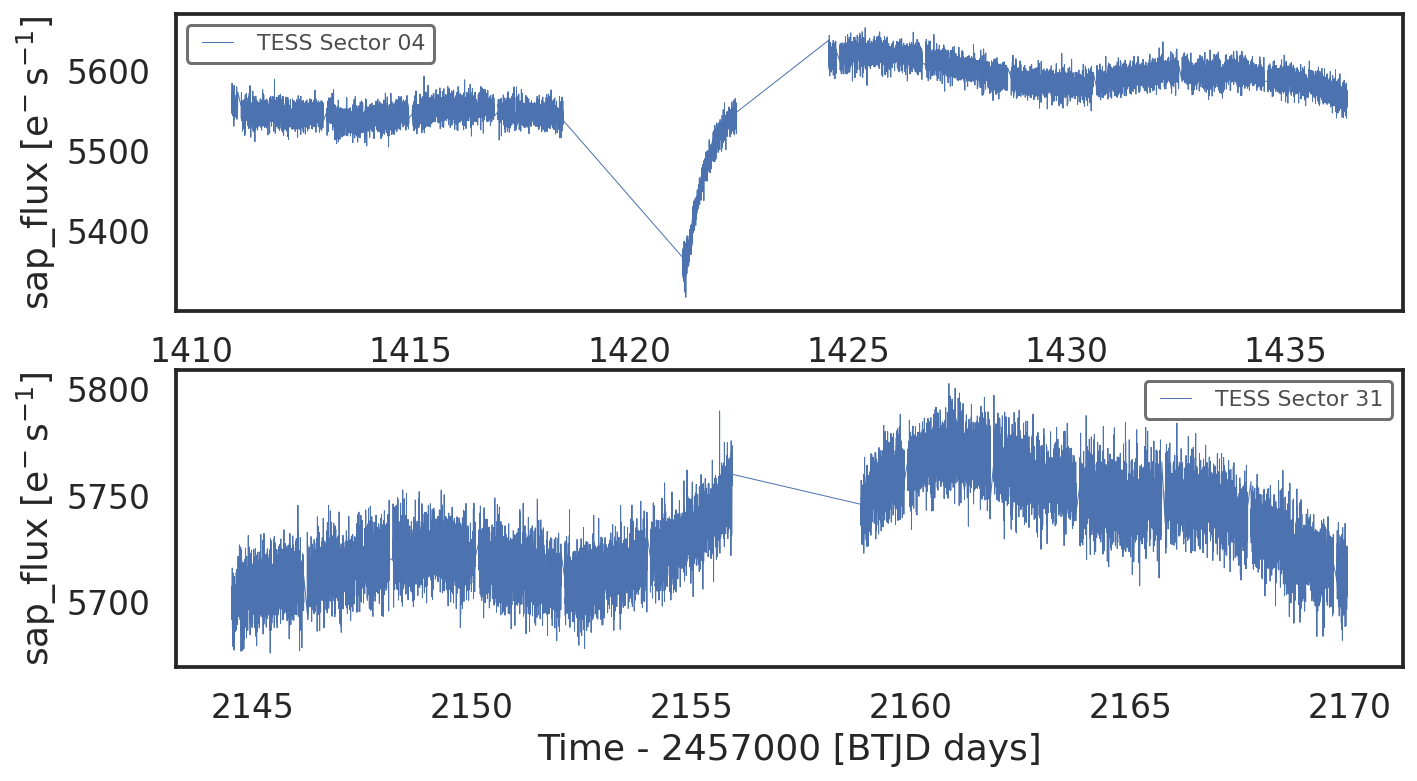

In [55]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6))

for (ax, lc, sr) in zip(axes.flat, lcs, srs):
    lc.plot(ax=ax, column='sap_flux', label=sr.mission[0])
    
ax.set_title("")

## PDCSAP

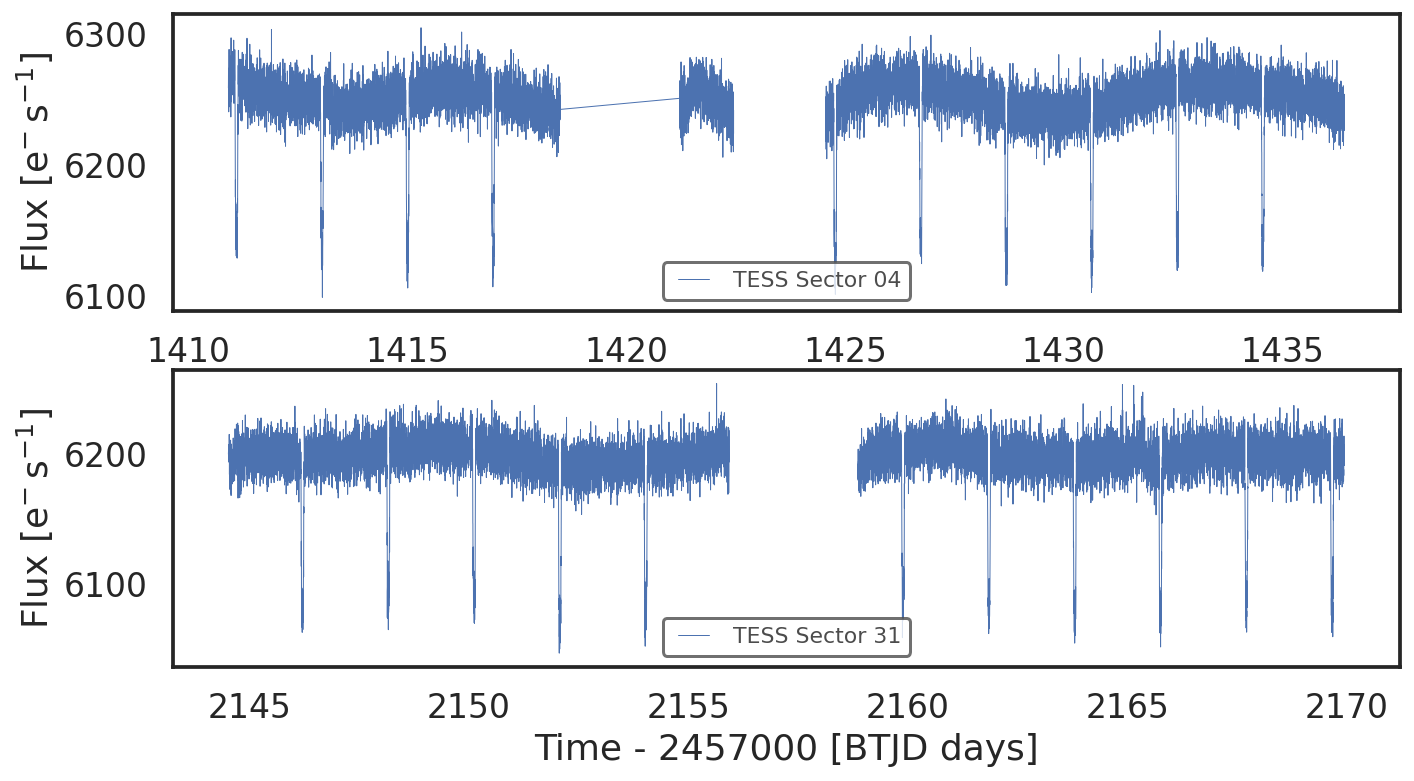

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6))

for (ax, lc, sr) in zip(axes.flat, lcs, srs):
    lc.plot(ax=ax, label=sr.mission[0])

Explicitly normalize and remove nans:

In [78]:
lc_sector_04 = lcs[0].normalize().remove_nans()
lc_sector_31 = lcs[1].normalize().remove_nans()

In [68]:
P = 1.9550931258
dur = 1.83 * (1.0 / 24.0)
t_0 = 2455558.61237

In [79]:
def compute_baseline(lc, P, dur, t_0):
    in_transit = tls.transit_mask(lc.time.jd, P, dur, t_0)
    lc_baseline = lc[~in_transit]
    return lc_baseline

In [80]:
lc_sector_04_baseline = compute_baseline(lc_sector_04, P, dur, t_0)
lc_sector_31_baseline = compute_baseline(lc_sector_31, P, dur, t_0)

## Baseline flux

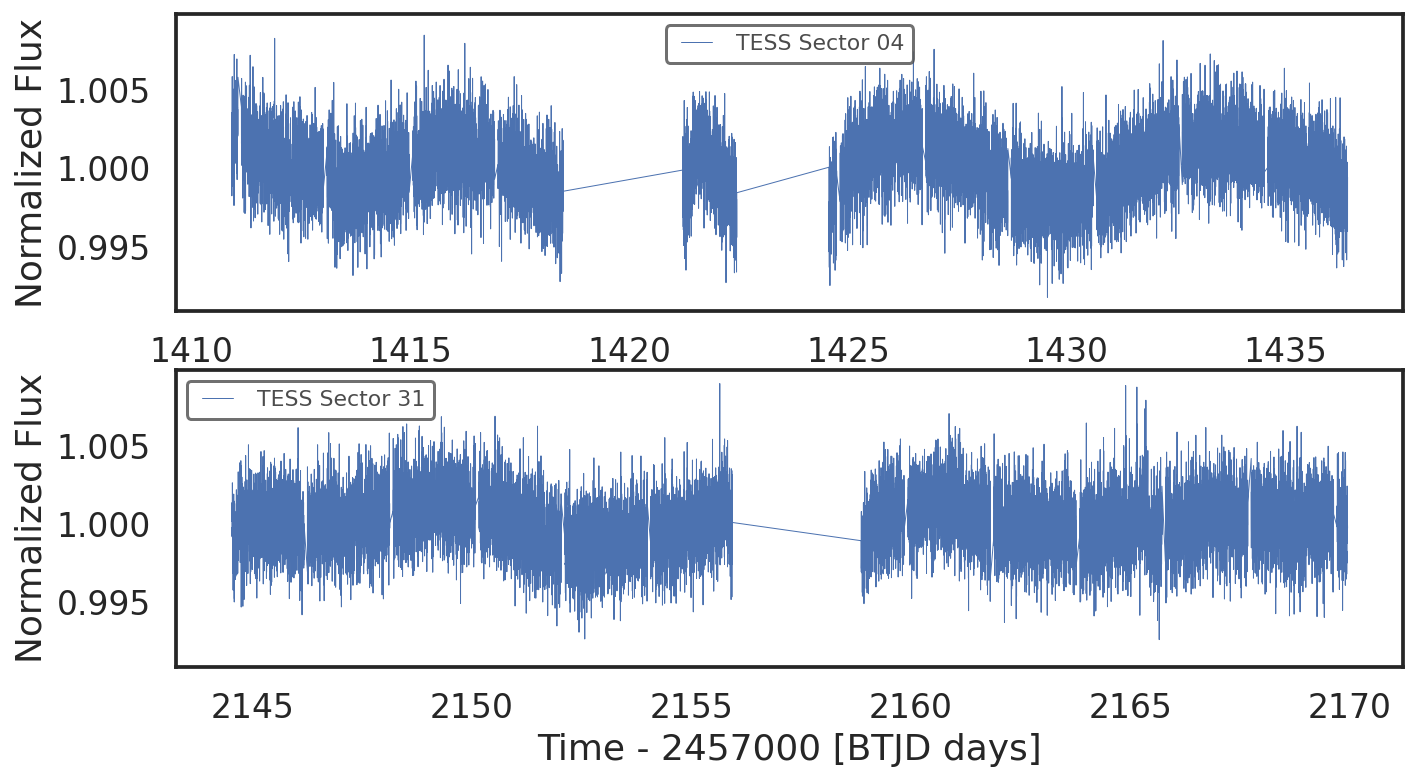

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharey=True)

lcs_baselines = [lc_sector_04_baseline, lc_sector_31_baseline]

for (ax, lc, sr) in zip(axes.flat, lcs_baselines, srs):
    lc.plot(ax=ax, label=sr.mission[0])

In [136]:
lcs_baselines[1].to_csv("../data/photometric/TESS_baseline_sector_31.csv")

## Binned baseline flux

In [96]:
def weighted_avg_and_std(values, weights):
    """ Return the weighted average and standard deviation. values, weights -- Numpy ndarrays with the same shape."""
    average = np.average(values, weights=weights) #weights = 1./err_bar^2. Where err_bar=std & err_bar^2 = variance
    variance = np.average((values-average)**2, weights=weights) # Fast and numerically precise
    return average, np.sqrt(variance)

def BinDat(time, LC, LC_err, Bin=100):
    """Method to bin the data, using the weighted mean of a given databin size 'Bin.' The error is estimated using the
    technique discussed here https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy"""
    Remainder = len(LC)%Bin
    LenSplit = int(np.trunc(len(LC)/Bin))
    if Remainder > 0: #To collect remainders for the last bin
        Main, mainErr, mainT= LC[:len(LC)-Remainder], LC_err[:len(LC_err)-Remainder], time[:len(time)-Remainder]
        Remain, RemainErr, remainT= LC[len(LC)-Remainder:], LC_err[len(LC_err)-Remainder:], time[len(time)-Remainder:]
        size = LenSplit+1
    else:
        Main, mainErr, mainT = LC, LC_err, time
        size = LenSplit
    BinLC, BinLCerr, BinT = np.zeros(size), np.zeros(size), np.zeros(size)
    Splits, splitErr, splitT = np.split(Main, LenSplit), np.split(mainErr, LenSplit), np.split(mainT, LenSplit)
    if Remainder: 
        Splits.append(Remain), splitErr.append(RemainErr), splitT.append(remainT)
    for S in range(len(Splits)):
        Avg, Err = weighted_avg_and_std(Splits[S], 1/(splitErr[S]**2)) #weight = 1/variance = 1/sig^2 = 1/err_bar^2
        BinLC[S], BinLCerr[S], BinT[S] = Avg, Err, np.mean(splitT[S])
    return BinLC, BinLCerr, BinT

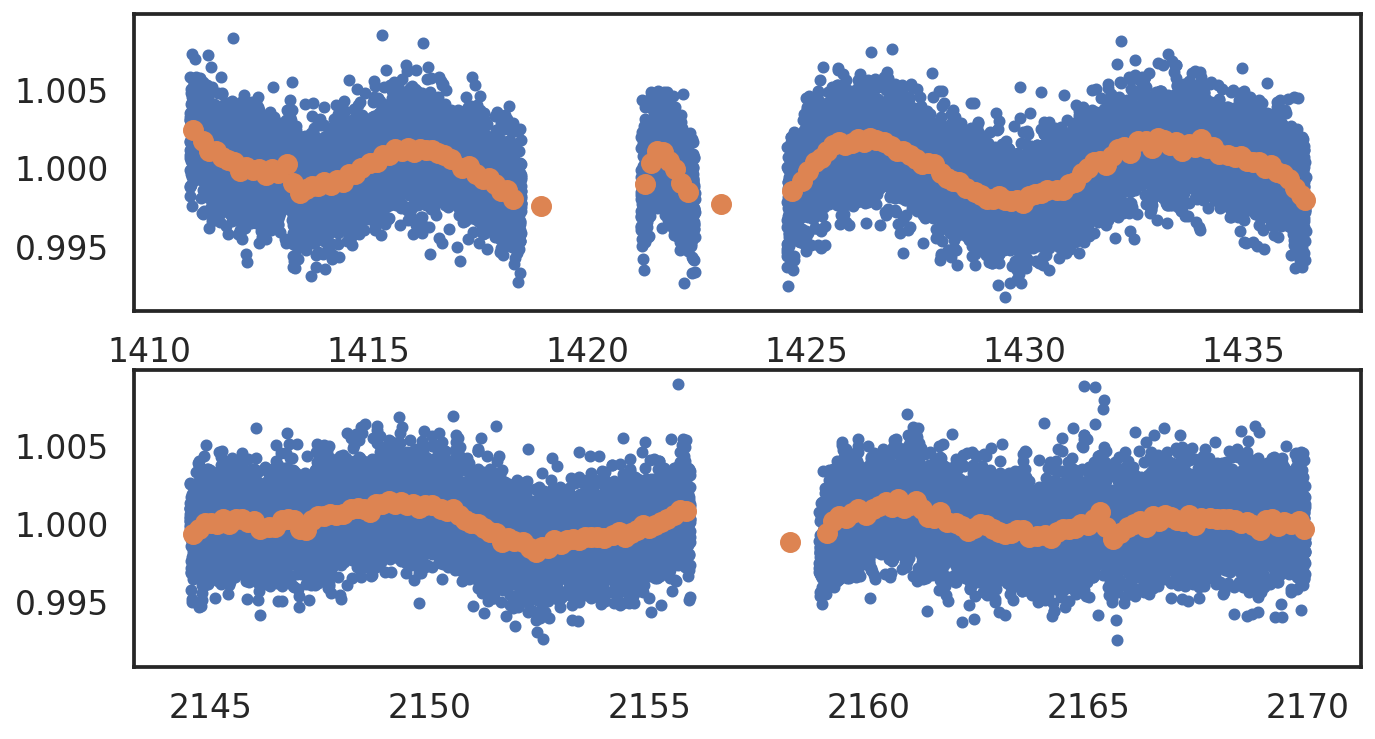

In [121]:
fig, axes = plt.subplots(2, 1, figsize=(11, 6), sharey=True)

for (ax, lc) in zip(axes.flat, lcs_baselines):
    binned_lc, binned_lc_err, binned_lc_time = BinDat(
        lc.time.btjd, lc.flux, lc.flux_err, Bin=100
    )
    ax.scatter(lc.time.btjd, lc.flux, marker='.')
    ax.scatter(binned_lc_time, binned_lc)